In [33]:
! pip install seaborn==0.11.2

  Using cached seaborn-0.11.2-py3-none-any.whl.metadata (2.3 kB)
Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_pft.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, plot_performance, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
sns.__version__

'0.12.2'

In [4]:
cohort_order = [              
 'Hugo',
 'Riaz',
 'Gide',
 'MGH',
 'Liu',
 'Allen',
 'SU2CLC2',
 'SU2CLC1',
 'IMmotion150',
 'Choueiri',
 'Miao',
 'IMVigor210',
 'Rose',
 'Snyder',           
 'Zhao',   
 'Kim']

import colorcet as cc
cohort_color = sns.color_palette(cc.glasbey, n_colors= len(cohort_order))
cohort_map = dict(zip(cohort_order, cohort_color.as_hex()))



In [5]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadcompass(mfile) #, map_location='cpu'

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))


df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfe, _ = pretrainer.predict(dfcx, batch_size=16)
dfy = df_label.response_label

100%|##########| 71/71 [00:04<00:00, 15.63it/s]


In [6]:
from compass.decoder import ProtoNetNFTDecoder

In [7]:
dfg_score, dfc_score = pretrainer.extract(dfcx, batch_size=16)

100%|##########| 71/71 [00:03<00:00, 19.53it/s]


In [8]:
dfg_score.columns

Index(['CANCER', 'Bcell_l_Danaher17', 'Bcell_sc', 'MemBcell_sc', 'NaiBcell_sc',
       'Plasma_sc', 'CD4Tcell_Combes22', 'CD4Tcell_IL2_I_Kaptein2022',
       'CD4Tcell_sc', 'Th17CD4Tcell_sc',
       ...
       'Cell_cycle', 'Cell_cycle_reg', 'Nucleotide_excision_repair',
       'Fanconi_anemia', 'Homologous_recombination', 'Base_excision_repair',
       'APOBEC_set', 'Ubiquitous_immune_sc', 'Ubiquitous_sc',
       'Reference_NanoString09'],
      dtype='object', length=133)

In [9]:
res = []
for dfx_used in [dfg_score, #[dfg_score.columns.difference(['UEG_set'])], 
                 dfc_score, #[dfc_score.columns.difference(['Reference'])],  #dfc_score, #
                 df_tpm]:
    
    mode = 'NFT_%s' % len(dfx_used.columns)
    for cohort in tqdm(cohorts, ascii=True):
    
        cohort_idx = df_label[df_label['cohort'] == cohort].index
        cohort_X = dfx_used.loc[cohort_idx]
        cohort_y = dfy.loc[cohort_idx]
    
        test_cohort_name = cohort
    
        predict_res = []
        for train_idx, test_idx in loo.split(cohort_idx):
            
            train_X = cohort_X.iloc[train_idx]
            train_y = cohort_y.iloc[train_idx]
            test_X = cohort_X.iloc[test_idx]    
            test_y = cohort_y.iloc[test_idx]
        
            support_set = train_X.join(train_y)
            query_set = test_X.join(test_y)
            
            NFT = ProtoNetNFTDecoder()
            NFT = NFT.fit(support_set)
            pred_testy = NFT.transform(query_set)
            
            pred_testy['cohort'] = test_cohort_name
            pred_testy['mode'] = mode
            predict_res.append(pred_testy)
    
        df_pred = pd.concat(predict_res)
        dfp = onehot(cohort_y.map({'PD':'NR', 'PR':'R',
                                   'SD':'NR', 'CR':'R',
                                   'NR':'NR', 'R':'R'})).join(df_pred)
    
        y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
        s2 = score2(y_true, y_prob, y_pred)
        
        dfs = pd.DataFrame([s2], columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC'], index = ['Test'])
        dfs['cohort'] = test_cohort_name
        dfs['mode'] = mode
        res.append(dfs)

100%|##########| 16/16 [00:56<00:00,  3.56s/it]


In [10]:
df = pd.concat(res)
df.head()

,ROC,PRC,F1,ACC,MCC,cohort,mode
Test,0.307692,0.128663,0.200000,0.500000,-0.100871,Choueiri,NFT_133
Test,0.383333,0.229879,0.166667,0.411765,-0.277746,Miao,NFT_133
Test,0.500000,0.298318,0.500000,0.523810,0.138675,Snyder,NFT_133
Test,0.308824,0.229077,0.363636,0.440000,-0.082918,SU2CLC2,NFT_133
Test,0.500000,0.418505,0.521739,0.560000,0.116131,Zhao,NFT_133


In [11]:
df['mode'].unique()

array(['NFT_133', 'NFT_44', 'NFT_15672'], dtype=object)

In [12]:
mode_dict = {'NFT_133':'p=133', 
             'NFT_44':'p=44', 
             'NFT_15672':'p=15672'}

df['mode'] = df['mode'].map(mode_dict)

In [13]:
df['mode'].unique()

array(['p=133', 'p=44', 'p=15672'], dtype=object)

In [14]:
x_order = df.groupby('mode')['MCC'].mean().sort_values(ascending=False).index

In [15]:
from itertools import combinations
from statannotations.Annotator import Annotator
box_pairs = list(combinations(x_order, 2))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p=44 vs. p=133: t-test paired samples, P_val:8.281e-02 t=1.859e+00
p=133 vs. p=15672: t-test paired samples, P_val:9.980e-02 t=1.754e+00
p=44 vs. p=15672: t-test paired samples, P_val:2.309e-03 t=3.663e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p=44 vs. p=133: t-test paired samples, P_val:8.780e-02 t=1.826e+00
p=133 vs. p=15672: t-test paired samples, P_val:1.092e-02 t=2.903e+00
p=44 vs. p=15672: t-test paired samples, P_val:8.044e-04 t=4.180e+00


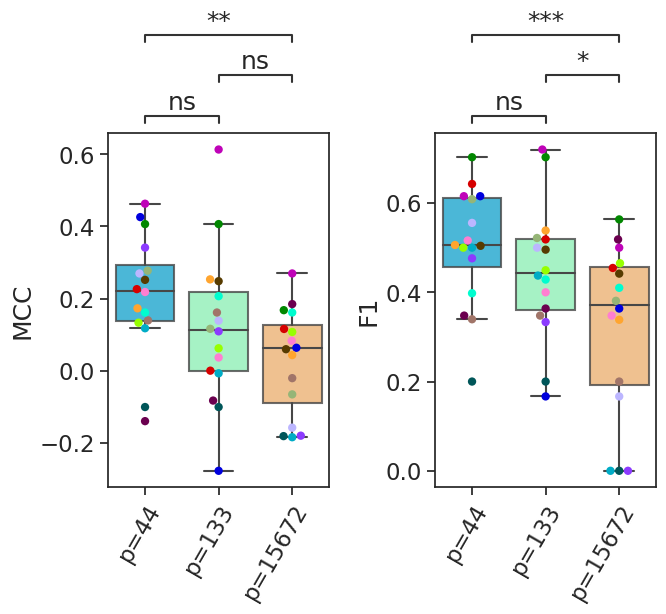

In [16]:
fig,axes = plt.subplots(figsize=(7,7), ncols=2, nrows=1)

(ax1, ax2) = axes

for ax, y in zip([ax1, ax2,], ['MCC', 'F1', ]):
    g = sns.swarmplot(data = df, x = 'mode', y = y, order = x_order, ax=ax, size=6,
                  palette=cohort_map, dodge=False, linewidth = 0.0, hue = 'cohort')

    g.get_legend().set_visible(False)
    
    sns.boxplot(data = df, x = 'mode', y = y, order = x_order, fliersize = 0, ax=ax, 
                palette='rainbow',  boxprops={'alpha':0.8})

    ax.tick_params(axis='both', which='major', 
                   right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(x_order, 
                        rotation=60, 
                        ha="right",  
                        rotation_mode="anchor")  # <====== HERE is the ke
    ax.set_xlabel('')

    annotator = Annotator(ax, pairs=box_pairs, data=df, x='mode', y=y, order=x_order)
    annotator.configure(test='t-test_paired', text_format='star', loc='outside',)
    annotator.apply_and_annotate()

fig.tight_layout()
fig.savefig('./Feature_level_impact_in_LOPO.svg', bbox_inches='tight')
df.to_csv('Source_data_Feature_level_impact_in_LOPO.csv')

In [17]:
cohort_map

{'Hugo': '#d60000',
 'Riaz': '#8c3bff',
 'Gide': '#018700',
 'MGH': '#00acc6',
 'Liu': '#97ff00',
 'Allen': '#ff7ed1',
 'SU2CLC2': '#6b004f',
 'SU2CLC1': '#ffa52f',
 'IMmotion150': '#573b00',
 'Choueiri': '#005659',
 'Miao': '#0000dd',
 'IMVigor210': '#00fdcf',
 'Rose': '#a17569',
 'Snyder': '#bcb6ff',
 'Zhao': '#95b577',
 'Kim': '#bf03b8'}

In [18]:
import math
import colorcet as cc
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True, anote = True, margin = 12, swatch_width = 30):

    cell_width = 230
    cell_height = 30
    swatch_width = swatch_width
    margin = margin

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

        if anote:
            ax.text(swatch_start_x, y, colors[name], fontsize=10,
                    horizontalalignment='left', color = 'white',
                    verticalalignment='center')

    return fig

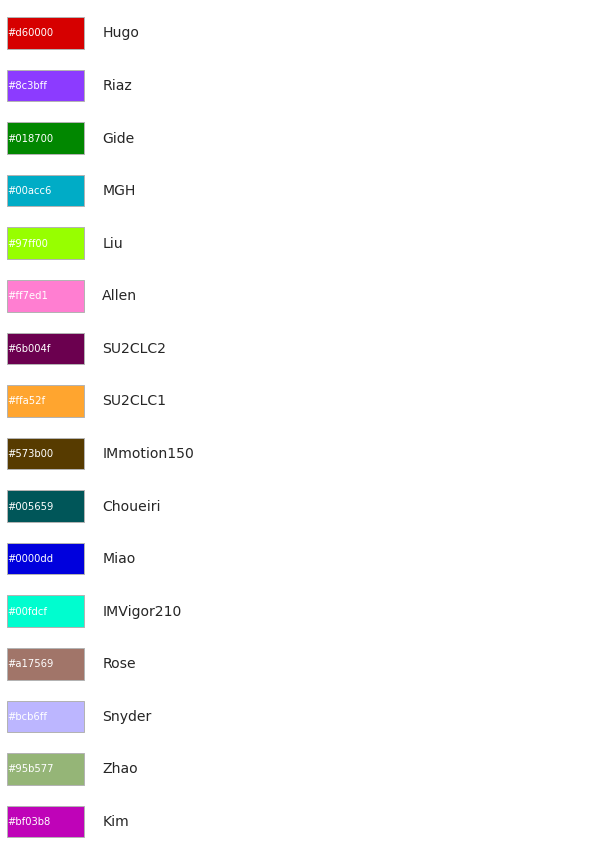

In [19]:
fig = plot_colortable(cohort_map, sort_colors = False, margin = 200, ncols=1)
fig.tight_layout()
fig.savefig('./cohort_color.pdf', bbox_inches='tight')